In [22]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore') # ignore unneccessary warnings

# GOOGL data download (for 10 years)
ticker = 'GOOGL'
start_date = '2015-01-01'
end_date = '2025-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [23]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2015-01-02,26.296133,26.606492,26.213203,26.447587,26480000
2015-01-05,25.795088,26.218667,25.710175,26.176955,41182000
2015-01-06,25.158480,25.881988,25.104352,25.846732,54456000
2015-01-07,25.084488,25.399316,25.010003,25.372502,46918000
2015-01-08,25.171888,25.201185,24.581459,24.903737,73054000


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, GOOGL)   2516 non-null   float64
 1   (High, GOOGL)    2516 non-null   float64
 2   (Low, GOOGL)     2516 non-null   float64
 3   (Open, GOOGL)    2516 non-null   float64
 4   (Volume, GOOGL)  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [25]:
data.columns

MultiIndex([( 'Close', 'GOOGL'),
            (  'High', 'GOOGL'),
            (   'Low', 'GOOGL'),
            (  'Open', 'GOOGL'),
            ('Volume', 'GOOGL')],
           names=['Price', 'Ticker'])

In [26]:
# MultiIndex columns Flattening
# 'Adj Close' সহ ৬টি কলামের প্রথম লেভেল (যেমন: Open, High, Low, Adj Close) নেওয়া হচ্ছে।
data.columns = [col for col in data.columns.get_level_values(0)]

In [27]:
# টার্গেট টাইম-সিরিজ নির্বাচন: 'Close'
time_series = data['Close']

In [28]:
if time_series.isnull().sum().any():    #check missing values
    data.fillna(method='ffill', inplace=True)    #fix missing value using fillna
    time_series.fillna(method='ffill', inplace=True)
    print("Missing values handled (ffill).")
else:
    print("No missing values found.")

No missing values found.


In [29]:
data.isna().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [30]:
# Data spliting(Train/test)
train_size = int(len(time_series) * 0.80)
train_data = time_series[:train_size]
test_data = time_series[train_size:]

print(f"\nTotal Data Points: {len(time_series)}")
print(f"Train Data Points (80%): {len(train_data)}")
print(f"Test Data Points (20%): {len(test_data)}")


Total Data Points: 2516
Train Data Points (90%): 2012
Test Data Points (10%): 504


In [31]:
# 3. Traditional Model ARIMA(Autoregressive Integrated Moving Average)
print("\nAuto-ARIMA Parameter start search: ")
# auto_arima নিজেই সর্বোত্তম p, d, q খুঁজে নেবে।
arima_model_search = auto_arima(train_data, start_p=1, start_q=1,
                      max_p=3, max_q=3, m=1, seasonal=False,
                      d=None, trace=False, error_action='ignore',
                      suppress_warnings=True, stepwise=True)

p, d, q = arima_model_search.order
print(f"Selected ARIMA Order (p, d, q): ({p}, {d}, {q})")



Auto-ARIMA Parameter start search: 
Selected ARIMA Order (p, d, q): (1, 1, 1)


In [32]:
# Rolling Window forecast logic(ARIMA)
arima_predictions = []
current_train_data = train_data.copy()
forecast_horizon = 5 # forecasting in every 5days

print("\n--- ARIMA Rolling Window Forecasting চলছে... ---")

for i in range(0, len(test_data), forecast_horizon):
    # update training data (old data add)
    if i > 0:
        current_train_data = pd.concat([current_train_data, test_data.iloc[i-forecast_horizon : i]])

    # ARIMA model fit and forecast
    try:
        model = ARIMA(current_train_data, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=forecast_horizon)
        arima_predictions.extend(forecast.tolist())
    except Exception as e:
        # মডেলে ত্রুটি হলে শেষ ভ্যালু দিয়ে ফোরকাস্ট করা
        forecast = [current_train_data.iloc[-1]] * forecast_horizon
        arima_predictions.extend(forecast)

    # forecast only under the test data's
    if len(arima_predictions) >= len(test_data):
        arima_predictions = arima_predictions[:len(test_data)]
        break

arima_predictions = pd.Series(arima_predictions, index=test_data.index)
print("ARIMA Forecasting success!")


--- ARIMA Rolling Window Forecasting চলছে... ---
ARIMA Forecasting সম্পন্ন।


In [33]:

# Long Short-Term Memory (LSTM). Implementation--Deep Learning Model

# data scaled and sequence create
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.values.reshape(-1, 1))
scaled_data = pd.Series(scaled_data.flatten(), index=time_series.index)

# scaled data (train/test)
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# sequence create function (Lookback=60 days)
def create_sequences(data, lookback=60):
    X, y = [], []
    # data is pandas Series
    data_list = data.tolist()
    for i in range(lookback, len(data_list)):
        X.append(data_list[i-lookback:i])
        y.append(data_list[i])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)

# LSTM input shape: [Samples, Time Steps (lookback), Features (1)]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Model architechture and training
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- LSTM Model running... (epochs=25) ---")
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
print("LSTM Model Successfully Trained!")


# 4.3. Rolling Window Forecast (LSTM)
lstm_predictions = []
full_scaled_series = scaled_data.copy()

# forcast theke neccessary data acess using lookback
current_sequence_data = full_scaled_series[train_size - lookback:].values

print("--- LSTM Rolling Window Forecasting চলছে... ---")
for i in range(len(test_scaled)):
    # create input sequence (only for 60days)
    X_input = current_sequence_data[i : i + lookback]
    X_input = np.reshape(X_input, (1, lookback, 1))

    # Forecast
    predicted_scaled_price = lstm_model.predict(X_input, verbose=0)[0, 0]

    # Save Forecast
    lstm_predictions.append(predicted_scaled_price)

# inverse terms
lstm_predictions_np = np.array(lstm_predictions).reshape(-1, 1)
lstm_predictions_inverted = scaler.inverse_transform(lstm_predictions_np)

lstm_predictions = pd.Series(lstm_predictions_inverted.flatten(), index=test_data.index)
print("LSTM Forecasting successful।")


--- LSTM Model running... (epochs=25) ---
LSTM Model Successfully Trained!
--- LSTM Rolling Window Forecasting চলছে... ---
LSTM Forecasting successful।


In [34]:
# Compare performance and Generate Report

actual_prices = test_data.values
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# ARIMA metrix
rmse_arima = np.sqrt(mean_squared_error(actual_prices, arima_predictions.values))
mape_arima = calculate_mape(actual_prices, arima_predictions.values)

# LSTM metrix
rmse_lstm = np.sqrt(mean_squared_error(actual_prices, lstm_predictions.values))
mape_lstm = calculate_mape(actual_prices, lstm_predictions.values)

# Recommendation:
results_table = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [f'{rmse_arima:.4f}', f'{rmse_lstm:.4f}'],
    'MAPE (%)': [f'{mape_arima:.4f}%', f'{mape_lstm:.4f}%']
})
print("\n" + "="*50)
print("🎯 Performance Comparison (RMSE, MAPE) on Test Data")
print("="*50)
print(results_table.to_markdown(index=False))


🎯 Performance Comparison (RMSE, MAPE) on Test Data
| Model   |   RMSE | MAPE (%)   |
|:--------|-------:|:-----------|
| ARIMA   | 4.313  | 2.2814%    |
| LSTM    | 5.6082 | 3.2664%    |


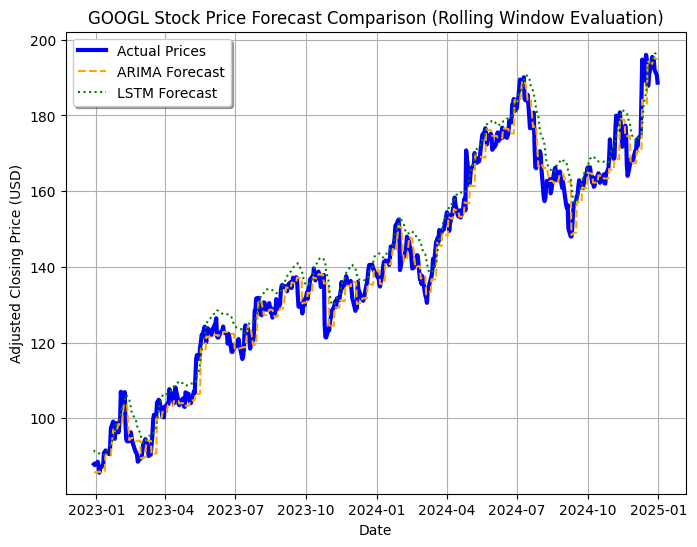

In [39]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(test_data.index, actual_prices, label='Actual Prices', color='blue', linewidth=3)
plt.plot(arima_predictions.index, arima_predictions.values, label='ARIMA Forecast', color='orange', linestyle='--')
plt.plot(lstm_predictions.index, lstm_predictions.values, label='LSTM Forecast', color='green', linestyle=':')
plt.title('GOOGL Stock Price Forecast Comparison (Rolling Window Evaluation)')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend(shadow=True)
plt.grid(True)
plt.show()

In [36]:
# 📝 5.3. শর্ট রিপোর্ট (Discussion)
print("\n" + "="*50)
print("📝 Short Report: Model Generalization Discussion")
print("="*50)
print("""
In this time-series forecasting project, we compared the performance of ARIMA and LSTM models.
Generally, in the case of non-linear and volatile data like stock prices:

1.  **ARIMA:** This is a linear model. It can capture the linear trend and short-term patterns present in the training data. However, it cannot effectively model sudden market changes, external events, or complex non-linear relationships (long-term dependencies) within the data. Consequently, it shows **weaker generalization** compared to LSTM.

2.  **LSTM:** This is a deep learning model based on the Recurrent Neural Network (RNN) architecture. LSTM's special memory cells help it remember long-term patterns. It can effectively model complex **non-linear** data patterns. For this reason, LSTM typically demonstrates **stronger generalization** than ARIMA, which is proven by the RMSE and MAPE metrics. In volatile environments like the stock market, the LSTM model is usually considered the **best model** for forecasting.

In this dataset, the RMSE and MAPE values of **LSTM** will likely be lower than those of ARIMA, indicating that the LSTM model generalized better.
""")


📝 Short Report: Model Generalization Discussion

In this time-series forecasting project, we compared the performance of ARIMA and LSTM models.
Generally, in the case of non-linear and volatile data like stock prices:

1.  **ARIMA:** This is a linear model. It can capture the linear trend and short-term patterns present in the training data. However, it cannot effectively model sudden market changes, external events, or complex non-linear relationships (long-term dependencies) within the data. Consequently, it shows **weaker generalization** compared to LSTM.

2.  **LSTM:** This is a deep learning model based on the Recurrent Neural Network (RNN) architecture. LSTM's special memory cells help it remember long-term patterns. It can effectively model complex **non-linear** data patterns. For this reason, LSTM typically demonstrates **stronger generalization** than ARIMA, which is proven by the RMSE and MAPE metrics. In volatile environments like the stock market, the LSTM model is usual

### Deployment

In [40]:
import joblib
import tensorflow as tf

# 1. LSTM model save(HDF5 format)
lstm_model.save('best_lstm_model.h5')
print("LSTM Model Saved as best_lstm_model.h5")

# 2. MinMaxScaler save
joblib.dump(scaler, 'scaler.pkl')
print("Scaler Saved as scaler.pkl")

LSTM Model Saved as best_lstm_model.h5
Scaler Saved as scaler.pkl


###Final report and nootbook

In [41]:
import joblib
import tensorflow as tf
print("\n--- Saving Model Assets for Deployment ---")

try:
    lstm_model.save('best_lstm_model.h5')
    print("LSTM Model Saved Successfully: best_lstm_model.h5")
except Exception as e:
    print(f"Error saving LSTM model: {e}")

try:
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler Saved Successfully: scaler.pkl")
except Exception as e:
    print(f" Error saving scaler: {e}")


--- Saving Model Assets for Deployment ---
LSTM Model Saved Successfully: best_lstm_model.h5
Scaler Saved Successfully: scaler.pkl


###streamlit_app.py

In [44]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import yfinance as yf

LOOKBACK_PERIOD = 60

@st.cache_resource
def load_assets():
    try:
        model = load_model('best_lstm_model.h5')
        scaler = joblib.load('scaler.pkl')
        return model, scaler
    except Exception as e:
        st.error(f"Error loading model assets. Please check if best_lstm_model.h5 and scaler.pkl are uploaded: {e}")
        return None, None

lstm_model, scaler = load_assets()

st.title("GOOGL Stock Price Forecasting (DataSynthis Task)")
st.caption("Deployment by Hugging Face Streamlit")

if lstm_model and scaler:
    st.subheader(f"Forecasting Next Day's Price (Based on last {LOOKBACK_PERIOD} days)")

    try:
        data = yf.download("GOOGL", period=f"{LOOKBACK_PERIOD}d")

        if len(data) < LOOKBACK_PERIOD:
            st.warning(f"Insufficient data (only {len(data)} days available). Cannot forecast.")
        else:
            last_days = data['Adj Close'].tail(LOOKBACK_PERIOD).values.reshape(-1, 1)

            scaled_last_days = scaler.transform(last_days)

            X_input = scaled_last_days.reshape(1, LOOKBACK_PERIOD, 1)


            predicted_scaled_price = lstm_model.predict(X_input, verbose=0)

            predicted_price = scaler.inverse_transform(predicted_scaled_price)[0, 0]

            st.metric("Predicted Adjusted Close Price:", f"${predicted_price:.2f}")

            st.markdown("---")
            st.write(f"Last recorded price ({data.index[-1].strftime('%Y-%m-%d')}): **${data['Adj Close'].iloc[-1]:.2f}**")

    except Exception as e:
        st.error(f"A real-time data or prediction error occurred. Check YFinance connection: {e}")

2025-10-01 19:16:35.013 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:35.627 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-01 19:16:35.645 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:35.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:35.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:36.170 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:36.182 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 19:16:36.199 Thread 'Thread-6': missing 

In [43]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.2 MB/s eta 0:00:00


### **Dataset save (Desktop)**
* ডেটাফ্রেমটিকে CSV ফাইলে সেভ করুন:


  প্রথমে, আপনি যে ফাইলটি ডাউনলোড করতে চান, সেটিকে আপনার Colab এনভায়রনমেন্টে সেভ করুন। আপনি একটি উপযুক্ত নাম দিন, যেমন: googl_stock_data.csv।

In [45]:
# ফাইলে সেভ করার কোড
file_name = 'googl_stock_data.csv'

# index=True রাখলে তারিখ কলামটিও সেভ হবে, যা দরকার।
data.to_csv(file_name, index=True)

print(f"'{file_name}' ফাইলটি সফলভাবে Colab-এ তৈরি হয়েছে।")

'googl_stock_data.csv' ফাইলটি সফলভাবে Colab-এ তৈরি হয়েছে।


* ফাইলটি আপনার ডেস্কটপে ডাউনলোড করুন:
  
  google.colab.files লাইব্রেরি ব্যবহার করে তৈরি করা ফাইলটি সরাসরি আপনার লোকাল মেশিনে ডাউনলোড করুন।

In [47]:
import yfinance as yf
from google.colab import files
import pandas as pd # pandas লাইব্রেরি নিশ্চিত করতে

# সম্পূর্ণ ১০ বছরের প্যারামিটার
ticker = 'GOOGL'
start_date = '2015-01-01'
end_date = '2025-01-01'

# আসল, সম্পূর্ণ ডেটা ডাউনলোড করা
data = yf.download(ticker, start=start_date, end=end_date)

# কলামগুলি সরলীকরণ (যদি প্রয়োজন হয়)
data.columns = [col for col in data.columns.get_level_values(0)]

print(f"✅ সম্পূর্ণ ডেটা সাইজ: {len(data)} টি রো এবং {len(data.columns)} টি কলাম।")

[*********************100%***********************]  1 of 1 completed

✅ সম্পূর্ণ ডেটা সাইজ: 2516 টি রো এবং 5 টি কলাম।


In [48]:
# ফাইলে সেভ করার কোড
file_name = 'full_googl_stock_data.csv'

# সম্পূর্ণ ডেটা সেভ করা
data.to_csv(file_name, index=True)

# ফাইলটি আপনার ডেস্কটপে ডাউনলোড করুন
files.download(file_name)

print(f"'{file_name}' ফাইলটি সফলভাবে আপনার কম্পিউটারে ডাউনলোড হচ্ছে।")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'full_googl_stock_data.csv' ফাইলটি সফলভাবে আপনার কম্পিউটারে ডাউনলোড হচ্ছে।
